Задание
Данные:

https://disk.yandex.ru/i/v5HM-ENiGXZVpQ

https://disk.yandex.ru/i/koR5eMCToCZS2Q

Задание 1. Задание: обучите три классификатора:

на токенах с высокой частотой

на токенах со средней частотой

на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

Задание 2. найти фичи с наибольшей значимостью, и вывести их

Задание 3.

сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

подобрать оптимальный размер для hashing векторайзера

убедиться что для сетки нет переобучения

In [1]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
from nltk import tokenize as tknz
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import wordnet
from nltk.corpus.reader.tagged import word_tokenize
from nltk.probability import FreqDist
from pymorphy2 import MorphAnalyzer
import re
from tqdm import tqdm 

from string import punctuation
from html import unescape

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression 
from collections import Counter

from sklearn import model_selection, preprocessing, linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evamelissatasdemir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/evamelissatasdemir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/evamelissatasdemir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/evamelissatasdemir/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
data = pd.concat([positive, negative]).reset_index(drop=True)
data.tail(10)

,text,label
226824,"@ivanenko14 и у меня также, только будильник е...",negative
226825,Когда же я вернусь к тебе(( http://t.co/36qnCO...,negative
226826,"RT @qelasocadij: Скажите пожалуйста, как у чел...",negative
226827,У нас физ ра на улице\nПака линт:(\nЧерез 45 м...,negative
226828,"Нас сегодня отказались принять в сад, типа мы ...",negative
226829,Но не каждый хочет что то исправлять:( http://...,negative
226830,скучаю так :-( только @taaannyaaa вправляет мо...,negative
226831,"Вот и в школу, в говно это идти уже надо(",negative
226832,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
226833,Такси везет меня на работу. Раздумываю приплат...,negative


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226834 entries, 0 to 226833
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    226834 non-null  object
 1   label   226834 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


In [4]:
def remove_word_user(input_txt):
    pattern = "@[\w]*"
    lst = re.findall(pattern, input_txt)
    result = input_txt
    for el in lst:
        result = re.sub(el, ' ', result)
    return result

data.text[0]

'@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)'

In [5]:
noise = stopwords.words('russian') + list(punctuation)

In [6]:
data['text'] = np.vectorize(remove_word_user)(data['text'])
data.head()

,text,label
0,"хоть я и школота, но поверь, у нас то же сам...",positive
1,"Да, все-таки он немного похож на него. Но мой ...",positive
2,RT : Ну ты идиотка) я испугалась за тебя!!!,positive
3,"RT : ""Кто то в углу сидит и погибает от голод...",positive
4,"Вот что значит страшилка :D\nНо блин,посмотр...",positive


In [7]:
def remove_noise(token, noise):
    """ 
    Removing noise from tokens.
    """
    remove_sw = [word for word in token if not word in noise]
    return  remove_sw

In [8]:
def get_lemmatizer(words, lemmatizer, pos):
    """
    lemmitization
    """
    lemmas = []
    for word in words:
        lemmas.append(lemmatizer.lemmatize(word, pos = nltk.corpus.wordnet.VERB) )
         
    return lemmas  

In [9]:
%%time

# Tokenizing
# Removing stop-words and punctuation
# Lemmatization

data['text_tokens'] = data['text'].apply(tknz.word_tokenize)
data['text_tokens'] = data['text_tokens'].apply(remove_noise, noise=noise)
data['text_tokens'] = \
        data['text_tokens'].apply(get_lemmatizer, lemmatizer = WordNetLemmatizer(), pos = wordnet.VERB)
data.head(3)

CPU times: user 53.1 s, sys: 857 ms, total: 53.9 s
Wall time: 58.2 s


,text,label,text_tokens
0,"хоть я и школота, но поверь, у нас то же сам...",positive,"[школота, поверь, самое, D, общество, профилир..."
1,"Да, все-таки он немного похож на него. Но мой ...",positive,"[Да, все-таки, немного, похож, Но, мальчик, ра..."
2,RT : Ну ты идиотка) я испугалась за тебя!!!,positive,"[RT, Ну, идиотка, испугалась]"


In [10]:
x_train, x_test, y_train, y_test = train_test_split(data.text, data.label)

In [69]:
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [70]:
y_train_word = y_train.copy()
y_train = [1 if elem == 'positive' else 0 for elem in y_train]
y_test_word = y_test.copy()
y_test = [1 if elem == 'positive' else 0 for elem in y_test]

In [11]:
corpus = [token for text in data.text for token in word_tokenize(text) if token not in punctuation]
print(len(corpus))
corpus[:10]

2721599


['хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то', 'же']

In [12]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

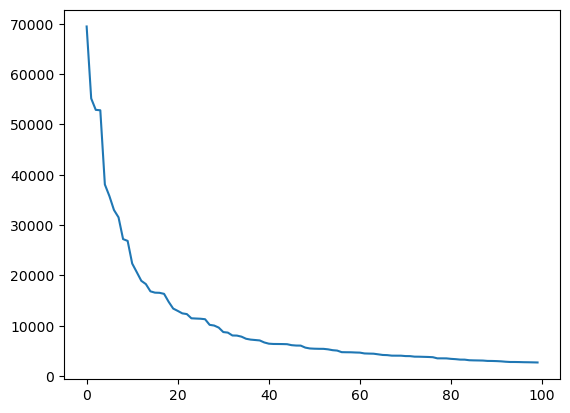

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

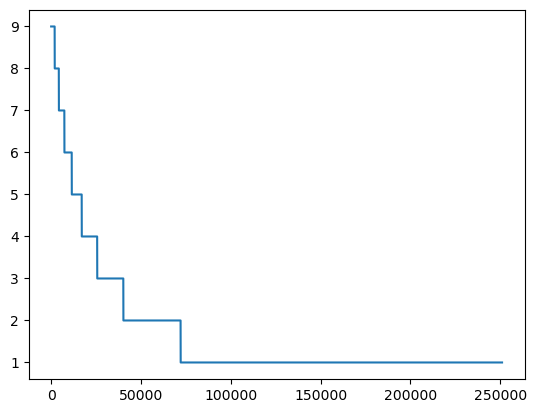

In [14]:
less_than_10_freq = [freq for word, freq in freq_dict_sorted if freq < 10]
plt.plot(less_than_10_freq)
plt.show()

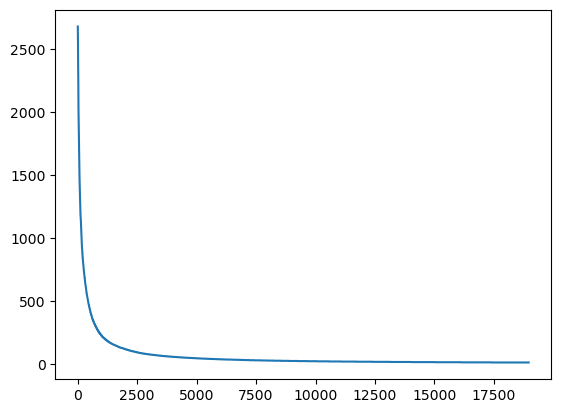

In [15]:
medium_freq = [freq for word, freq in freq_dict_sorted[100:-len(less_than_10_freq)]]
plt.plot(medium_freq)
plt.show()

In [16]:
print(f'Dictionary length: {len(freq_dict_sorted)}, high frequency: {len(first_100_freqs)},\
 medium frequency: {len(medium_freq)}, low frequency: {len(less_than_10_freq)}')

Dictionary length: 270108, high frequency: 100, medium frequency: 18968, low frequency: 251040


In [17]:
noise = stopwords.words('russian') + list(punctuation)
tok_cnt_high = CountVectorizer(min_df=1, max_df=0.9, tokenizer=word_tokenize, stop_words=noise)
tok_cnt_mid = CountVectorizer(min_df=1e-3, max_df=0.7, tokenizer=word_tokenize, stop_words=noise)
tok_cnt_low = CountVectorizer(min_df=1e-5, max_df=0.3, tokenizer=word_tokenize, stop_words=noise)     

In [18]:
bow_cnt_high = tok_cnt_high.fit_transform(x_train)
lr = LogisticRegression(random_state=42)
lr.fit(bow_cnt_high, y_train)
pred_high = lr.predict(tok_cnt_high.transform(x_test))
print(classification_report(pred_high, y_test))

              precision    recall  f1-score   support

    negative       0.79      0.75      0.77     29204
    positive       0.75      0.78      0.76     27505

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



In [19]:
bow_cnt_mid = tok_cnt_mid.fit_transform(x_train)
lr.fit(bow_cnt_mid, y_train)
pred_mid = lr.predict(tok_cnt_mid.transform(x_test))
print(classification_report(pred_mid, y_test))

              precision    recall  f1-score   support

    negative       0.74      0.69      0.72     29901
    positive       0.68      0.73      0.70     26808

    accuracy                           0.71     56709
   macro avg       0.71      0.71      0.71     56709
weighted avg       0.71      0.71      0.71     56709



In [20]:
bow_cnt_low = tok_cnt_low.fit_transform(x_train)
lr.fit(bow_cnt_low, y_train)
pred_low = lr.predict(tok_cnt_low.transform(x_test))
print(classification_report(pred_low, y_test))

              precision    recall  f1-score   support

    negative       0.78      0.75      0.77     28986
    positive       0.75      0.78      0.76     27723

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



In [21]:
tok_tfidf_high = TfidfVectorizer(min_df=1, max_df=0.9, tokenizer=word_tokenize, stop_words=noise)
tok_tfidf_mid = TfidfVectorizer(min_df=1e-3, max_df=0.7, tokenizer=word_tokenize, stop_words=noise)
tok_tfidf_low = TfidfVectorizer(min_df=1e-5, max_df=0.3, tokenizer=word_tokenize, stop_words=noise)     

In [22]:
bow_tfidf_high = tok_tfidf_high.fit_transform(x_train)
lr = LogisticRegression(random_state=42)
lr.fit(bow_tfidf_high, y_train)
pred_high = lr.predict(tok_tfidf_high.transform(x_test))
print(classification_report(pred_high, y_test))

              precision    recall  f1-score   support

    negative       0.76      0.77      0.76     27672
    positive       0.77      0.77      0.77     29037

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



In [23]:
bow_tfidf_mid = tok_tfidf_mid.fit_transform(x_train)
lr.fit(bow_tfidf_mid, y_train)
pred_mid = lr.predict(tok_tfidf_mid.transform(x_test))
print(classification_report(pred_mid, y_test))

              precision    recall  f1-score   support

    negative       0.72      0.70      0.71     28873
    positive       0.70      0.72      0.71     27836

    accuracy                           0.71     56709
   macro avg       0.71      0.71      0.71     56709
weighted avg       0.71      0.71      0.71     56709



In [24]:
bow_tfidf_low = tok_tfidf_low.fit_transform(x_train)
lr.fit(bow_tfidf_low, y_train)
pred_low = lr.predict(tok_tfidf_low.transform(x_test))
print(classification_report(pred_low, y_test))

              precision    recall  f1-score   support

    negative       0.76      0.76      0.76     28044
    positive       0.77      0.77      0.77     28665

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



In [25]:
vec_hash_2 = HashingVectorizer(analyzer='char', n_features=2, stop_words=noise)
vec_hash_4 = HashingVectorizer(analyzer='char', n_features=4, stop_words=noise)
vec_hash_16 = HashingVectorizer(analyzer='char', n_features=16, stop_words=noise)

In [26]:
#bow_hash = HashingVectorizer(n_features=4)
bow_hash_2 = vec_hash_2.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow_hash_2, y_train)
pred = clf.predict(vec_hash_2.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.54      0.61      0.57     24691
    positive       0.67      0.60      0.63     32018

    accuracy                           0.60     56709
   macro avg       0.60      0.61      0.60     56709
weighted avg       0.61      0.60      0.61     56709



In [27]:
bow_hash_4 = vec_hash_4.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow_hash_4, y_train)
pred = clf.predict(vec_hash_4.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.56      0.62      0.59     25555
    positive       0.66      0.61      0.63     31154

    accuracy                           0.61     56709
   macro avg       0.61      0.61      0.61     56709
weighted avg       0.62      0.61      0.61     56709



In [28]:
bow_hash_16 = vec_hash_16.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow_hash_16, y_train)
pred = clf.predict(vec_hash_16.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.83      0.79      0.81     29286
    positive       0.79      0.83      0.81     27423

    accuracy                           0.81     56709
   macro avg       0.81      0.81      0.81     56709
weighted avg       0.81      0.81      0.81     56709



In [29]:
# or in the cycle:
hash_features = [2 ** i for i in range(18)]
for num in hash_features:
    print('n_features =', num)
    vec_hash = HashingVectorizer(analyzer='char', n_features=num, stop_words=noise)
    bow_hash = vec_hash.fit_transform(x_train)
    x_test_hash = vec_hash.transform(x_test)
    clf = LogisticRegression(random_state=42)
    clf.fit(bow_hash, y_train)
    pred = clf.predict(vec_hash.transform(x_test))
    print(classification_report(pred, y_test))
    print()

n_features = 1
              precision    recall  f1-score   support

    negative       0.73      0.56      0.63     36757
    positive       0.43      0.62      0.51     19952

    accuracy                           0.58     56709
   macro avg       0.58      0.59      0.57     56709
weighted avg       0.63      0.58      0.59     56709


n_features = 2
              precision    recall  f1-score   support

    negative       0.54      0.61      0.57     24691
    positive       0.67      0.60      0.63     32018

    accuracy                           0.60     56709
   macro avg       0.60      0.61      0.60     56709
weighted avg       0.61      0.60      0.61     56709


n_features = 4
              precision    recall  f1-score   support

    negative       0.56      0.62      0.59     25555
    positive       0.66      0.61      0.63     31154

    accuracy                           0.61     56709
   macro avg       0.61      0.61      0.61     56709
weighted avg       0.62    

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [31]:
tokenizer = WordPunctTokenizer()

In [37]:
train_corpus = " ".join(x_train.values)
train_corpus = train_corpus.lower()


In [39]:
%%time
tokens = word_tokenize(train_corpus)
tokens_filtered = [word for word in tokens]

CPU times: user 8min 26s, sys: 3min 16s, total: 11min 42s
Wall time: 12min 51s


In [41]:
index_count= 0
voc_inv = {}
vocabulary = {}
for key in dict(Counter(tokens_filtered).most_common(2000)).keys():
    voc_inv[index_count] = key
    vocabulary[key] = index_count
    index_count += 1
# vocabulary

In [42]:
def text_to_sequence(text, maxlen):
  result=[]
  tokens = word_tokenize(text.lower())
  tokens_filtered = [word for word in tokens if word.isalnum()]
  for word in tokens_filtered:
    if word in vocabulary:
      result.append(vocabulary[word])
  padding = [0] * (maxlen - len(result))
  return result[-maxlen:] + padding

In [66]:

max_len = len(vocabulary)
num_classes = 1


In [71]:
%%time
x_train_for_nn = np.array([text_to_sequence(text, max_len) for text in x_train.values], dtype=np.int32)
x_test_for_nn = np.array([text_to_sequence(text, max_len) for text in x_test.values], dtype=np.int32)

CPU times: user 1min 3s, sys: 4.68 s, total: 1min 8s
Wall time: 1min 11s


In [72]:
x_train_for_nn.shape

(170125, 2000)

In [73]:
x_train_for_nn[:5]

array([[  11,    6,  548, ...,    0,    0,    0],
       [  13,   17,   20, ...,    0,    0,    0],
       [  13,    6,  149, ...,    0,    0,    0],
       [  43,  141,  207, ...,    0,    0,    0],
       [  11, 1269,  158, ...,    0,    0,    0]], dtype=int32)

In [75]:
x_train.iloc[:5]

0              RT  : Я думал Надеко, а это не она. :-(
1      а у меня настолько наоборот %) я долго не мо...
2           а я ее, похоже, только завтра посмотрю...(
3    Только один человек может меня подбодрить и вс...
4    RT  : Группа Внутренних Войск взята под охрану...
Name: text, dtype: object

In [76]:
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [78]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
batch_size = 128
max_words = 50
epochs = 2

model = Net(vocab_size=len(vocabulary)).to(device)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()
    
train_dataset = DataWrapper(x_train_for_nn, np.array(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        
        # data = data.cuda()
        # target = target.cuda()
        
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
        if i%400 == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history.append(loss)

LSTMFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 520321
Train epoch 1/2
Step 0: loss=0.6882001161575317


In [ ]:
# train_dataset = DataWrapper(x_train_for_nn, np.array(y_train))
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DataWrapper(x_test_for_nn, np.array(y_test))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

In [ ]:
batch_size = 128
max_words = 50
epochs = 2

In [ ]:
lstm_init =LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr = 0.001)
criterion = nn.BCELoss()

In [ ]:
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

In [ ]:
lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    lstm_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

In [ ]:
plt.title('lstm Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()

In [ ]:
model.eval()
list_accuracy = []
for data in test_loader:
  test_outputs = model(data[0].to(device))
  label = data[1].to(device)
  predict = torch.max(test_outputs, 1)[1]
  break
print(classification_report(predict.cpu(), label.cpu())

In [ ]:
list_accuracy = []
for data in test_loader:
  test_outputs = model(data[0].to(device))
  label = data[1].to(device)
  predict = torch.max(test_outputs, 1)[1]
  list_accuracy.append((predict == label).sum()/predict.shape[0])
np.mean([elem.cpu() for elem in list_accuracy])